In [2]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

from PIL import Image

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

## First define the functions we will need to use
### The Structural Image Autocorrelation (SIA) function is the second function defined below

In [11]:
### this function (newRadav) finds the radial average of the image autocorrelation in the SIA function 
def newRadav(im, limangles=False, angRange=None, mask=None, rev=False,
             debug_q = None):
    if mask is None:
        hasMask = False
    else:
        hasMask = True
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    #x,y = np.meshgrid(xx,yy)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    angles = np.arctan2(x,y)
    
    qx = np.arange(-1*nx/2,nx/2)*(1./nx) * max(nx,ny)
    qy = np.arange(-1*ny/2,ny/2)*(1./ny) * max(nx,ny)
    qxx,qyy = np.meshgrid(qy,qx) #qy,qx is correct order
    q_new = np.sqrt(qxx**2 + qyy**2)
    
    if debug_q is not None:
        return q_new.round().astype(int)==debug_q
    
    if mask is None:
        mask = np.ones_like(angles)
    if angRange is not None:
        w1 = np.where(angles>angRange[0])
    else:
        w1 = np.where(angles>(13*np.pi/14))
    if mask is None:
        mask[w1]=0
        mask = mask * np.rot90(np.rot90(mask))
        mask = mask * np.flipud(mask)
        mask[np.where(mask==0)] = np.nan
        if rev:
            mask = np.rot90(mask)
    qr = q_new.round().astype(int)
    #rs = np.arange(0,(nx-1)/2)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            if limangles or hasMask:
                newim = im*mask
                radav[i] = np.nanmean(newim[w])
            else:
                radav[i] = np.nanmean(im[w])
        #else:
        #    print i
    return radav

def SIA_threshold_images(im, filter, fsize):
    if filter:
        im = filtimage(im, filtersize= fsize)
    else:
        im = im
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    sys.setrecursionlimit(rows*cols)
    med = np.median(imarray)
    thresh = 1.09*med  #1.8*med
    if key == 2:
        if i == 5:
            imarray = imarray + 20
        if i == 6:
            imarray = imarray + 60
        if i == 7:
            imarray = imarray + 100
        if i > 7:
            imarray = imarray + 120
    #print(thresh)
    arraythresh = (imarray) > thresh
    threshimage = Image.fromarray(arraythresh)
    #mark unclustered pixels with -1
    marked_arraythresh = -1*(imarray > thresh)
    return marked_arraythresh
    #return marked_arraythresh, threshimage

### the SIA function 
def SIA(image, filter = True, fsize=600, bin=True, binsize=2):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    
    ### Crop image
    #image = image[:1440, :1440]    ###option to crop out any large noise features 

    image = SIA_threshold_images(image, filter, fsize)
        #image = image*1.0 - uf(image,filtersize)   ###uniform filter, removes background. ("filtersize" is pixel area)
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)   ### OPTIONAL (binning makes things run faster)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = np.real(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    ### radial average taken
    rav_corr = newRadav(corr_im)
    
    ### return ONLY rav_corr **b/c I don't need corr_im** (change this if you do need corr_im) 
    return rav_corr

###define the single exponential we use to fit SIA curves
str_equation = False
def single_exponential(x, A, cl):
    #return (np.exp(-x/cl) + A) 
    if str_equation == True:
        return "(1-A)*exp(-x/cl) + A"
    else:
        return (1-A)*(np.exp(-x/cl)) + A

### define function to systematically reduce the fit length until the fit parameters meet the specific criteria
###### this function was much more relevant for finicky double exponential fits, it doesn't do much for single exponential fits
def check_fits(A, l1, y_array, retry_num):
    if A == r1_A:
        row = "(r1) "
    elif A == r2_A:
        row = "(r2) "
    else:
        row = "(r3) "
    j=1
    skip_to_next = 0
    if (A < 0.0001) or (l1 > 180.0): ##this line sets the specific criteria for fit params to meet
        try_again = True
        print("     poor fit at "+row+ time)
        while try_again:
            new_fit_lim = fit_lim - ((2*j))
            x_fit_lim = all_xvalues[new_fit_lim]
            try:
                popt, pcov = curve_fit(single_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], p0 = [0.5,7.0])
            except RuntimeError:
                print("RuntimeError - curve_fit failed")
                skip_to_next = 1
            print("        "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, l1=%5.3f' % tuple(popt))
            A, l1 = tuple(popt)
            x_fit_values = np.linspace(all_xvalues[1], all_xvalues[new_fit_lim], 1000)
            if (j == (retry_num-1)) or ((np.abs(l1)) < 0.1):
                print("   poor fit at "+row+ time + " --> try double exponential fit?")
                try_again = False
                try_single = True
                i = 0

            elif (A < 0.049) or (skip_to_next == 1):
                try_again = True
                skip_to_next = 0
                j = j+1
            else:
                try_again = False
                print("  yay!! good fit at "+row+time)
                print("  "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, l1=%5.3f' % tuple(popt))
    return [A, l1]

### filtimage removes the background 
def filtimage(image, filtersize=600):
    image = (image/100)**1.6 #(array)^1.6 to increase contrast (i think this works?)
    image = (image*10) +1000
    image = (image*1.0) - ((uf(image,filtersize))*1)  #(image) - unifrom-filtered(image) subtracts background
    image = image + 1500  #return pixel array values back to their original range 
    return image

### the following functions ('show_threshold_images', and 'show_filtered_images') are used to preview 
### the images intended for analysis
def show_raw_images(row, ax, i, frame_key):
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        test_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
        print(files[i+index_add])
    ax.imshow(test_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

def show_filtered_images(fsize, row, ax, i, frame_key, filt):
    index_add = arr_length * (row -1)
    #print(files[i+index_add])
    if time_array[i] == 0:
        empty_im = np.zeros((1440,1920))
        ax.imshow(empty_im, cmap = 'gray')
        ax.set_title('[no image]', fontsize=10)
    elif filt == False:
        ax.imshow(raw_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        filtered_image = filtimage(raw_image, filtersize= fsize)
        ax.imshow(filtered_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize="+str(fsize)+")", fontsize=10)
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(fsize, row, ax, i, frame_key, filt):
    index_add = arr_length * (row -1)
    return_marked = False
    if time_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        threshold_image = threshold_images(fsize, raw_image, i, return_marked, filt)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def threshold_images(fsize, im, i, return_marked, filt):
    if filt == False:
        im = im
    else:
        im = filtimage(im, filtersize= fsize)
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    sys.setrecursionlimit(rows*cols)
    med = np.median(imarray)
    if frame_key == 2:
        if i == 5:
            imarray = imarray + 20
        if i == 6:
            imarray = imarray + 60
        if i == 7:
            imarray = imarray + 105
        if i > 7:
            imarray = imarray + 125
    thresh = 1.09*med #1.12*med  #1.8*med
    arraythresh = (imarray) > thresh
    threshimage = Image.fromarray(arraythresh)
### mark unclustered pixels with -1
    marked_arraythresh = -1*(imarray > thresh)
    if return_marked == False:
        return threshimage
    if return_marked == True:
        return marked_arraythresh
    #return marked_arraythresh, threshimage

## Locate your data (tiff files) and choose where to save results     

In [55]:
directory = "Z"
exp = "9-5-22_s1_theBigOne"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\SIA preview images\\" #bottom_row_t01\\

### "plot_saveto" is the pathway to the folder where plots and results will be saved
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 27 files
 0 	 row1_t01.tif
 1 	 row1_t02.tif
 2 	 row1_t03.tif
 3 	 row1_t04.tif
 4 	 row1_t05.tif
 5 	 row1_t06.tif
 6 	 row1_t07.tif
 7 	 row1_t08.tif
 8 	 row1_t09.tif
 9 	 row2_t01.tif
 10 	 row2_t02.tif
 11 	 row2_t03.tif
 12 	 row2_t04.tif
 13 	 row2_t05.tif
 14 	 row2_t06.tif
 15 	 row2_t07.tif
 16 	 row2_t08.tif
 17 	 row2_t09.tif
 18 	 row3_t01.tif
 19 	 row3_t02.tif
 20 	 row3_t03.tif
 21 	 row3_t04.tif
 22 	 row3_t05.tif
 23 	 row3_t06.tif
 24 	 row3_t07.tif
 25 	 row3_t08.tif
 26 	 row3_t09.tif


## Specify pixel size, each condition (frame_names), and the time points of data collection (time_array)

In [57]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s1 [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s2 [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.364 # 4*0.091 = 0.364
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/3)
print("total number of time points: "+ str(arr_length))
if arr_length % 2 == 0:
    num_rows = int(arr_length/2)
else:
    num_rows = int((arr_length+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

tiff file dimensions: (5, 1440, 1920)
total number of time points: 9
(for image previews) number of rows = 5


## Choose size, font, and quality level (dpi_num) for the plots to be made

In [58]:
fig_size = 10,10/1.618
###  size of output figures
font_size = 16
### font size
dpi_num = 600
### image quality level (recommendation: 600)

# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

condition: 1-3 kA-WT


<IPython.core.display.Javascript object>


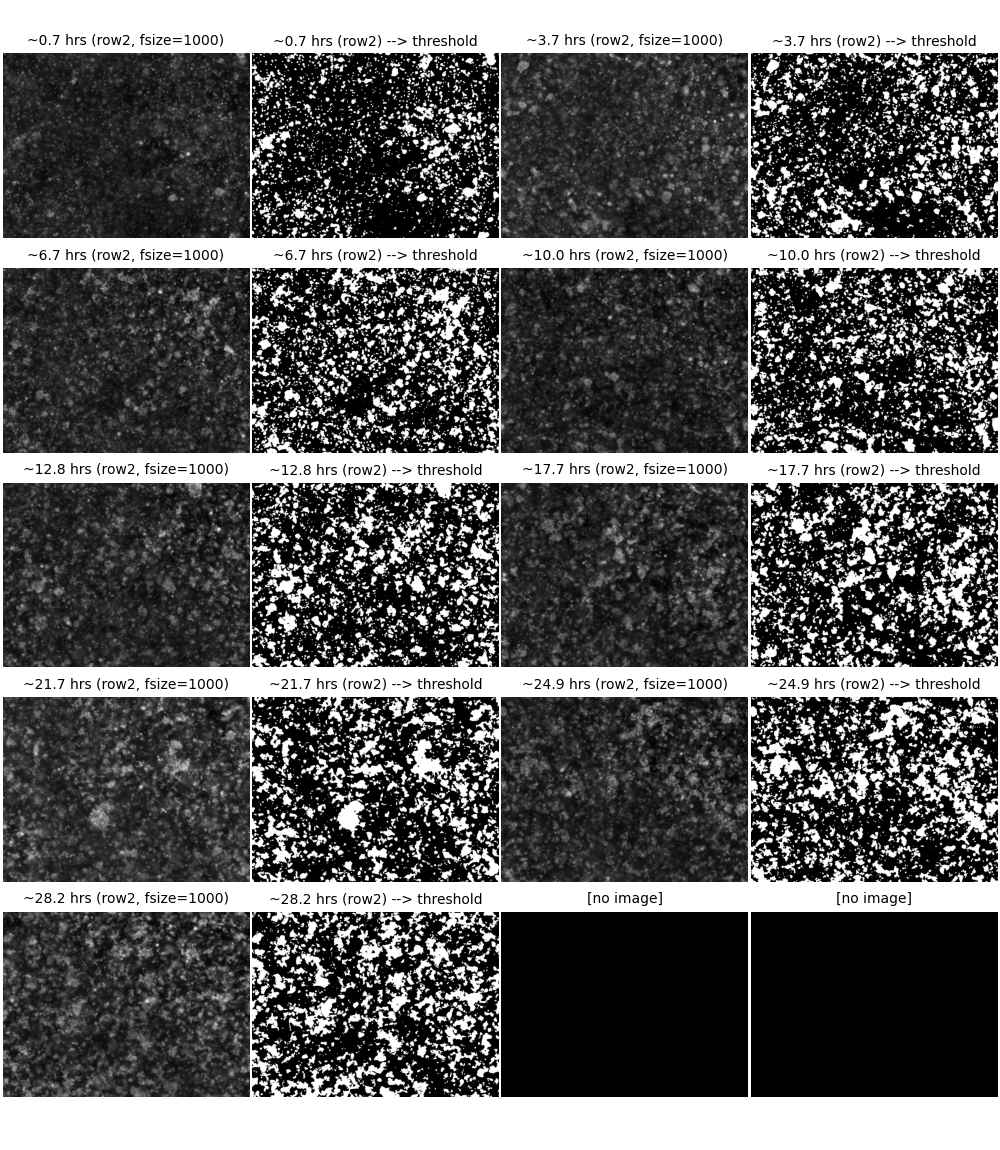

[0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]


In [60]:
frame_key = 0
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed
condition = frame_names[frame_key]
print("condition: "+condition)

fsize = 1000
filt = True
### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600
if filt == False:
    f = "none" 
else:
    f = str(fsize)

row = 2
### choose which set of tiff files should be analyzed, row1, row2 or row3

fig_height = num_rows*2.3
time_array.append(0)
i = 0
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_filtered_images(fsize, row, ax, i, frame_key, filt)
    else:
        show_threshold_images(fsize, row, ax, i, frame_key, filt)
        i = i + 1 
plt.show()
time_array.remove(0)
print(time_array)

### option to save this figure (uncomment below)
fig.savefig(data_dir2+"threshold vs filtered images for "+condition+" (row"+str(row)+", f="+f+")"+".jpg", dpi=dpi_num)

## Now we can run some SIA! 

In [47]:
#time_array.remove(0)
print(time_array)

[1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7]


<IPython.core.display.Javascript object>


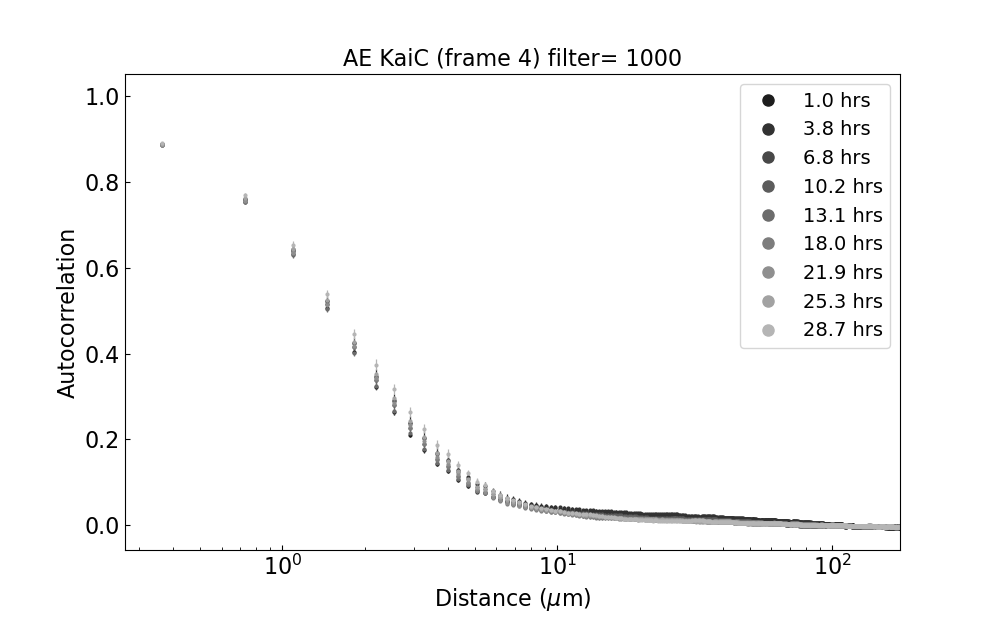

radial image size: 174.356 x 174.356 um, last x-value= 174.356


<ipython-input-48-fcdd06c1b429>:76: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [48]:
### "key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed, tiff_file.imread(files[i],key=[key]
key = 3

### cmap dictates the color gradient used in plots; options: 'Reds' 'Blues' 'Greens' 'Greys' 'Purples' ...
cmap = matplotlib.cm.get_cmap('Greys')  

### If true, filters images to remove excess fluorescense background or other noise
t_f = True
_bin = True

### set filter size (pixel area used to estimate and remove average background pixel intensities, recommendation = 600
size = 1000  

### Set up empty arrays to save results in
im_array = [0.0] * int(arr_length)
r1_corr_rad_array = [0.0] * int(arr_length)
r2_corr_rad_array = [0.0] * int(arr_length)
r3_corr_rad_array = [0.0] * int(arr_length)
r4_corr_rad_array = [0.0] * int(arr_length)
r5_corr_rad_array = [0.0] * int(arr_length)
r6_corr_rad_array = [0.0] * int(arr_length)
all_xvalues = [0.0] * int(len(files))

### Set basic plot design 
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

### cmap_num is used the when plotting each curve to adjust the color gradient according to the total number of time points
### e.g. for i in range(arr_length): the color of each curve is determined by c=cmap(0.9-(i/cmap_num))
cmap_num = (arr_length*2) - 2

### Set up more empty arrays to save results in
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1)    ### used in plot title to specify which frame of all tiff files was analyzed
    data_file = str(time_array[i]) + " hrs" ### used in legend to show time points corresponding to each curve
    
### "im_corr" is the actual SIA function which filters, bins, and fourier transforms tiff images to generate SIA curves
    r1_corr_rad_array[i] = SIA(tiff_file.imread(files[i],key=[key]),filter=t_f,fsize=size, bin=_bin, binsize=2)
    
    r2_corr_rad_array[i] = SIA(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,fsize=size, bin=_bin, binsize=2)
    r3_corr_rad_array[i] = SIA(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,fsize=size, bin=_bin, binsize=2)
    
### corresponding x-values calculated according to the length of a SIA curve array (r1_corr_rad_array[0]) and pixel size
    all_xvalues = np.arange(len(r1_corr_rad_array[0]))*pixel_size
    
### this block calculates the average and std error of the 3 SIA curves ("r1_corr_rad_array[i]", "r2_corr_rad_array[i]", and 
### "r3_corr_rad_array[i]") generated from the specified frame (key) of 3 tiff files corresponding to time point "time_array[i]"
    all_ims = np.zeros((3,len(r1_corr_rad_array[i])))
    all_ims[0] = r1_corr_rad_array[i]
    all_ims[1] = r2_corr_rad_array[i]
    all_ims[2] = r3_corr_rad_array[i]

    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
### plot the average SIA curves for each time point with the std error as error bars 
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) 
    
print("radial image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))

### legend, labels and title for the plot 
### **note: the title determined in this code block carries over to all other plots unless otherwise specified 
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
ax.tick_params(direction='in', which='both', labelsize=font_size)

### x-axis limit is set slighlty larger than the image size, based on "all_xvalues[-1]" 
plt.xlim(0, all_xvalues[-1] +2) 

### set title
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [49]:
###save figure 
fig.savefig(plot_saveto+"threshold SIA avg, error for "+title+".jpg", dpi=dpi_num)
print(plot_saveto)

Z:\Gregor L\__Kai Colloids\SIA\Data\9-5-22_s2_theBigOne\


## Now we fit the SIA curves to a single exponential, fit equation: y = e^(-x/L1) + A

<IPython.core.display.Javascript object>


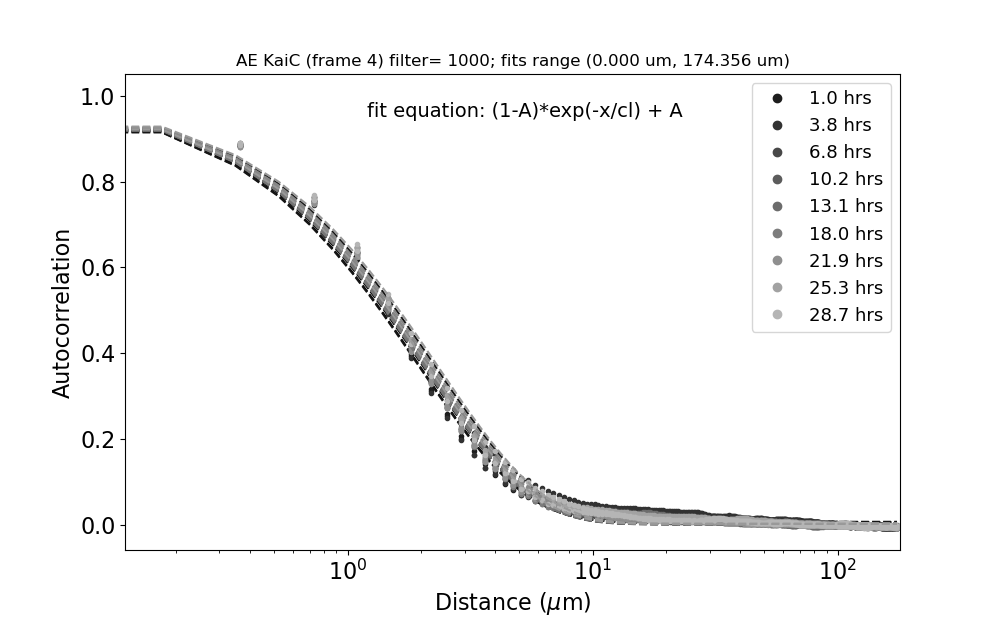

first x-value= 0.364, start fits at 0.000; fit until xlim = 174.356
Fits:
1.0 hrs-- r1 fit: A=0.006, l1=2.021
1.0 hrs-- r2 fit: A=0.007, l1=2.102
1.0 hrs-- r3 fit: A=0.006, l1=1.961
3.8 hrs-- r1 fit: A=0.008, l1=2.259
3.8 hrs-- r2 fit: A=0.008, l1=2.318
3.8 hrs-- r3 fit: A=0.007, l1=1.944
6.8 hrs-- r1 fit: A=0.001, l1=2.062
6.8 hrs-- r2 fit: A=0.004, l1=2.166
6.8 hrs-- r3 fit: A=0.004, l1=2.095
10.2 hrs-- r1 fit: A=0.003, l1=2.160
10.2 hrs-- r2 fit: A=0.004, l1=2.293
10.2 hrs-- r3 fit: A=0.002, l1=2.068
13.1 hrs-- r1 fit: A=0.002, l1=2.084
13.1 hrs-- r2 fit: A=0.003, l1=1.938
13.1 hrs-- r3 fit: A=0.004, l1=2.122
18.0 hrs-- r1 fit: A=0.002, l1=2.077
18.0 hrs-- r2 fit: A=0.004, l1=2.114
18.0 hrs-- r3 fit: A=0.004, l1=2.078
21.9 hrs-- r1 fit: A=0.002, l1=2.054
21.9 hrs-- r2 fit: A=0.003, l1=2.222
21.9 hrs-- r3 fit: A=0.002, l1=2.091
25.3 hrs-- r1 fit: A=0.002, l1=2.181
25.3 hrs-- r2 fit: A=0.002, l1=2.154
25.3 hrs-- r3 fit: A=0.005, l1=2.221
28.7 hrs-- r1 fit: A=0.003, l1=2.335
28.7 hrs--

<ipython-input-50-c325f0b57eec>:97: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'AE KaiC (frame 4) filter= 1000; fits range (0.000 um, 174.356 um)')

In [50]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

### Set up dictionary ("results_dict") and more empty arrays to save results in
results_dict = {}
results_dict["time array"] = time_array

r1_params = [0.0] * arr_length
r2_params = [0.0] * arr_length
r3_params = [0.0] * arr_length

### FIT PARAMETERS: adjust these to change the range for fitting attempts 
fit_start = 0
fit_lim = -1 
retry_num = 10 #retry_num is the number of fitting attempts to try before moving on, not very relevant to single exp fits
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits at %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[fit_start], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]

### load and plot the 3 original SIA curves corresponding to 3 tiff files associated with each time point 
    r1_y_array = r1_corr_rad_array[i]
    r2_y_array = r2_corr_rad_array[i]
    r3_y_array = r3_corr_rad_array[i]
    plt.semilogx(all_xvalues,r1_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    #plt.plot(all_xvalues,r2_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.plot(all_xvalues,r3_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
### x_fit_values has the same range as "all_xvalues", but includes more values to produce better fits
    x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000) 

### the "curve_fit" function from scipy does the initial fitting attempt
    r1_popt, r1_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r1_y_array[fit_start:fit_lim])
    r2_popt, r2_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r2_y_array[fit_start:fit_lim])
    r3_popt, r3_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r3_y_array[fit_start:fit_lim])
    print(time+"-- "+'r1 fit: A=%5.3f, l1=%5.3f' % tuple(r1_popt))
    print(time+"-- "+'r2 fit: A=%5.3f, l1=%5.3f' % tuple(r2_popt))
    print(time+"-- "+'r3 fit: A=%5.3f, l1=%5.3f' % tuple(r3_popt))
    r1_A, r1_cl = tuple(r1_popt)
    r2_A, r2_cl = tuple(r2_popt)
    r3_A, r3_cl = tuple(r3_popt)
    
### the "check fits" function re-runs "curve_fit" with a slightly smaller range until the fit parameters meet our criteria
### specified in the "check fits" function, our fit parameters criteria was more relevant for double exponential fits
### (most single exponential fits work first try)
    #r1_A, r1_cl = check_fits(r1_A, r1_cl, r1_y_array, retry_num)
    #r2_A, r2_cl = check_fits(r2_A, r2_cl, r2_y_array, retry_num)
    #r3_A, r3_cl = check_fits(r3_A, r3_cl, r3_y_array, retry_num)
    
### generate and plot curves based on the fits 
    r1_fit_values = single_exponential(x_fit_values, *r1_popt)
    r2_fit_values = single_exponential(x_fit_values, *r2_popt)
    r3_fit_values = single_exponential(x_fit_values, *r3_popt)
    plt.plot(x_fit_values, r1_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    #plt.plot(x_fit_values, r2_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.plot(x_fit_values, r3_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
### saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["r1 y vals"] = r1_y_array
    results_dict[time]["r2 y vals"] = r2_y_array
    results_dict[time]["r3 y vals"] = r3_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["r1 fit vals"] = r1_fit_values
    results_dict[time]["r2 fit vals"] = r2_fit_values
    results_dict[time]["r3 fit vals"] = r3_fit_values
    
    results_dict[time]["r1 fit params"] = [r1_A, r1_cl]
    results_dict[time]["r2 fit params"] = [r2_A, r2_cl]
    results_dict[time]["r3 fit params"] = [r3_A, r3_cl]
    
    r1_params[i] = (r1_A, r1_cl)
    r2_params[i] = (r2_A, r2_cl) 
    r3_params[i] = (r3_A, r3_cl)
    #print("br_yarray[0] = %5.3f, br_yarray[1] = %5.3f, br_fit_values[0] = %5.3f, br_fit_values[1] = %5.3f" %(br_y_array[0], 
      #                                                                                                   br_y_array[1],
       #                                                                                                  br_fit_values[0], 
                #                                                                                         br_fit_values[1]))
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-3)
#plt.ylim(0.1, 1.1)
#plt.ylim(0.006, 1.01)
#plt.xlim(0, 5)
#plt.xlim(0, all_xvalues[-10]+5)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
str_equation = True
equation = single_exponential(x_fit_values, *r1_popt)
ax.text(1.2,0.95, "fit equation: " + equation, fontsize=font_size-2)
str_equation = False

title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)

In [51]:
###save figure
fig.savefig(plot_saveto+"threshold SIA fits for "+title_plus+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "threshold SIA results for "+title+".p", "wb")
#file_to_write = open(plot_saveto+ "SIA results for "+title_plus+".p", "wb")
pickle.dump(results_dict, file_to_write)

## Determine and plot the results of fitting SIA curves

<IPython.core.display.Javascript object>


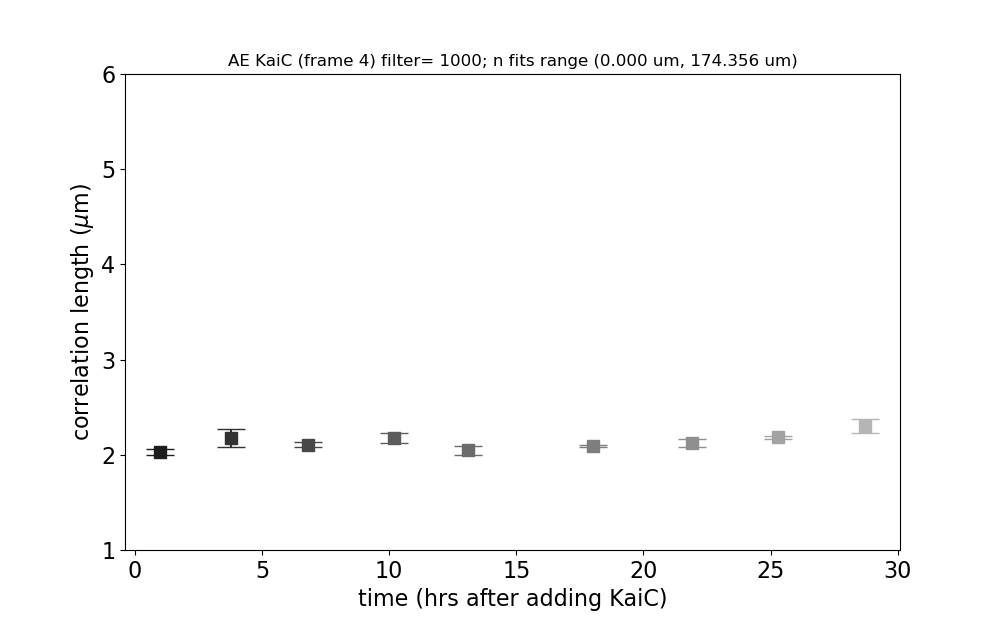

In [52]:
array_len = len(r1_params)
### set up empty arrays
all_cl = np.zeros((3,array_len))
avg_cl = np.empty(array_len)
stderror_cl = np.empty(array_len)

### find average values and std. error for correlation lengths (lc) based on the fits 
for i in range(array_len):
    all_cl[0,i] = r1_params[i][1]
    all_cl[1,i] = r2_params[i][1]
    all_cl[2,i] = r3_params[i][1]
avg_cl = all_cl.mean(axis=0)
stderror_cl = (all_cl.std(axis=0))/np.sqrt(3)   #
#print(all_cl)
#print(all_cl.mean(axis=0))
#print(stderror_cl)

### plot average values and std. error for correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_cl[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_cl[i], yerr = stderror_cl[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(1,6)
title_plus = title + "; n fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+"threshold correlation lengths for "+title_plus+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


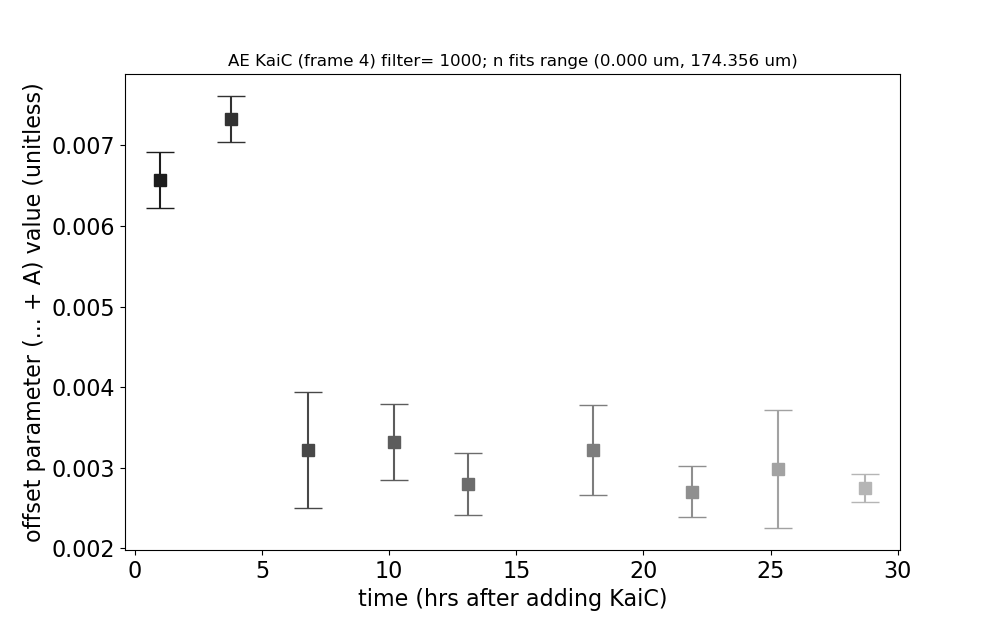

In [53]:
array_len = len(r1_params)
### set up empty arrays
all_A = np.zeros((3,array_len))
avg_A = np.empty(array_len)
stderror_A = np.empty(array_len)

### find average values and std. error for correlation lengths (lc) based on the fits 
for i in range(array_len):
    all_A[0,i] = r1_params[i][0]
    all_A[1,i] = r2_params[i][0]
    all_A[2,i] = r3_params[i][0]
avg_A = all_A.mean(axis=0)
stderror_A = (all_A.std(axis=0))/np.sqrt(3)   #
#print(all_cl)
#print(all_cl.mean(axis=0))
#print(stderror_cl)

### plot average values and std. error for correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_A[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_A[i], yerr = stderror_A[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("offset parameter (... + A) value (unitless)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
#plt.ylim(0.001,0.04)
title_plus = title + "; n fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+"threshold _offset parameter values for "+title_plus+".jpg", dpi=dpi_num)

## Save all results to 3 seperate CSV files --> use for plotting in origin later on 

In [54]:

### first CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = "results- threshold SIA fit parameters.csv"
data_file_exists = os.path.isfile(plot_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['time (hrs)','','r1 A','r2 A','r3 A','','avg A', 'A std E','','','r1 cL','r2 cL','r3 cL','', 
                         'avg cL', 'cL std E'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i],'', r1_params[i][0], r2_params[i][0], r3_params[i][0],'', avg_A[i], stderror_A[i],'','',
                             r1_params[i][1], r2_params[i][1], r3_params[i][1],'', avg_cl[i], stderror_cl[i]])
        writer.writerow([''])
    f.close()
    print("Results appended to "+ csv_data_file)
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['time (hrs)','','r1 A','r2 A','r3 A','','avg A', 'A std E','','','r1 cL','r2 cL','r3 cL','', 
                         'avg cL', 'cL std E'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i],'', r1_params[i][0], r2_params[i][0], r3_params[i][0],'', avg_A[i], stderror_A[i],'','',
                             r1_params[i][1], r2_params[i][1], r3_params[i][1],'', avg_cl[i], stderror_cl[i]])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to "+ csv_data_file)

### BOX PLOTS CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = "Box Plot results- threshold SIA fit parameters.csv"
data_file_exists = os.path.isfile(plot_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['','A values','','','','','','','','','','','','correlation length'])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1', r1_params[1][0], r1_params[2][0], r1_params[3][0], r1_params[4][0], r1_params[5][0],
                         r1_params[6][0], r1_params[7][0], r1_params[8][0], r1_params[i][0],'','',
                         'row1', r1_params[1][1], r1_params[2][1], r1_params[3][1], r1_params[4][1], r1_params[5][1],
                         r1_params[6][1], r1_params[7][1], r1_params[8][1], r1_params[i][1],'','',])
        
        writer.writerow(['row2', r2_params[1][0], r2_params[2][0], r2_params[3][0], r2_params[4][0], r2_params[5][0],
                         r2_params[6][0], r2_params[7][0], r2_params[8][0], r2_params[i][0],'','',
                         'row2', r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1], r2_params[5][1],
                         r2_params[6][1], r2_params[7][1], r2_params[8][1], r2_params[i][1],'','',])
        
        writer.writerow(['row3', r3_params[1][0], r3_params[2][0], r3_params[3][0], r3_params[4][0], r3_params[5][0],
                         r3_params[6][0], r3_params[7][0], r3_params[8][0], r3_params[i][0],'','',
                         'row3', r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1], r2_params[5][1],
                         r3_params[6][1], r3_params[7][1], r3_params[8][1], r3_params[i][1],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to "+ csv_data_file)
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['','A values','','','','','','','','','','','','correlation length'])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1', r1_params[1][0], r1_params[2][0], r1_params[3][0], r1_params[4][0], r1_params[5][0],
                         r1_params[6][0], r1_params[7][0], r1_params[8][0], r1_params[i][0],'','',
                         'row1', r1_params[1][1], r1_params[2][1], r1_params[3][1], r1_params[4][1], r1_params[5][1],
                         r1_params[6][1], r1_params[7][1], r1_params[8][1], r1_params[i][1],'','',])
        
        writer.writerow(['row2', r2_params[1][0], r2_params[2][0], r2_params[3][0], r2_params[4][0], r2_params[5][0],
                         r2_params[6][0], r2_params[7][0], r2_params[8][0], r2_params[i][0],'','',
                         'row2', r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1], r2_params[5][1],
                         r2_params[6][1], r2_params[7][1], r2_params[8][1], r2_params[i][1],'','',])
        
        writer.writerow(['row3', r3_params[1][0], r3_params[2][0], r3_params[3][0], r3_params[4][0], r3_params[5][0],
                         r3_params[6][0], r3_params[7][0], r3_params[8][0], r3_params[i][0],'','',
                         'row3', r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1], r2_params[5][1],
                         r3_params[6][1], r3_params[7][1], r3_params[8][1], r3_params[i][1],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to "+ csv_data_file)
    
### second CSV file: save raw data (x and y values) of each original SIA curve (3 curves for each time point)
csv_data_file = "results- threshold SIA raw data"+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','','r1 y vals','r2 y vals','r3 y vals','','avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i],'', results_dict[time]['r1 y vals'][i],
                            results_dict[time]['r2 y vals'][i], results_dict[time]['r3 y vals'][i],'',
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

### third CSV file: save the raw data (x and y values) of each fit to each original SIA curve (3 curves for each time point)
csv_data_file = "results- threshold SIA fits data"+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','','r1 fit vals','r2 fit vals','r3 fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], '', results_dict[time]['r1 fit vals'][i],
                            results_dict[time]['r2 fit vals'][i], results_dict[time]['r3 fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

results- threshold SIA fit parameters.csv already exists.
Results appended to results- threshold SIA fit parameters.csv
Box Plot results- threshold SIA fit parameters.csv already exists.
Results appended to Box Plot results- threshold SIA fit parameters.csv


## First round complete! 
## Now we can scroll back to the top and change the 'key' variable to run through the next frame (i.e. condition) of all tiff files